In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, log_loss
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn.linear_model import LogisticRegression
import warnings
import xgboost as xgb
import lightgbm as lgb

warnings.filterwarnings('ignore')

# Notes

- we could show crossfold and variance of simple decision trees with a crossfold? 
- Also maybe we need to change the dataset, because currently the random forest is actually more variable than the simple decision tree
- Explain out of bag in little text box below random forest

<br><br>
# **Table of Contents**

- [Decision Trees](#decision-trees)
  - [Dataset Overview: Synthetic Heart Disease Prediction](#dataset-overview-synthetic-heart-disease-prediction)
  - [Interpreting the Decision Tree Results](#interpreting-the-decision-tree-results)
- [Random Forests](#random-forests)
  - [Interpreting Random Forest vs Single Tree Results](#interpreting-random-forest-vs-single-tree-results)
  - [How Random Forest Creates "Wisdom of Crowds"](#how-random-forest-creates-wisdom-of-crowds)
  - [Understanding Feature Importance Rankings](#understanding-feature-importance-rankings)
  - [Understanding Feature-Risk Relationships](#understanding-feature-risk-relationships)
  - [How Partial Dependence Plots Work](#how-partial-dependence-plots-work)
- [Gradient Boosting: Learning from Mistakes](#gradient-boosting-learning-from-mistakes)
- [Random Forest vs Gradient Boosting: Quick Comparison](#random-forest-vs-gradient-boosting-quick-comparison)

<br><br>
# **Hands-On: Decision Trees and Random Forest**

## Learning Goals
By the end of this session, you will be able to:

- **Build and interpret decision tree models**
  - Create decision trees for classification using synthetic heart disease data
  - Read decision tree visualizations and understand splitting criteria and decision paths

- **Implement ensemble methods for improved predictions**
  - Apply Random Forest to combine multiple decision trees and reduce overfitting
  - Compare single tree performance vs. ensemble "wisdom of crowds" approach

- **Analyze feature importance and relationships**
  - Extract and interpret feature importance rankings from Random Forest models
  - Use partial dependence plots to understand how individual features affect predictions

- **Apply gradient boosting for sequential learning**
  - Implement gradient boosting algorithms that learn from previous model mistakes
  - Compare Random Forest (parallel) vs. Gradient Boosting (sequential) ensemble strategies

<br><br>
# **Decision Trees**

Decision trees mirror how healthcare professionals naturally make clinical decisions - through a series of **if-then questions** based on patient characteristics, symptoms, and test results.

**Core Concept:**
A decision tree splits data into subgroups by asking binary questions about features, creating a tree-like structure that leads to predictions.

**Medical Example:**
Patient has chest pain?<br>
├── Yes → Age > 65?<br>
│ ├── Yes → High risk of cardiac event<br>
│ └── No → Check cholesterol levels?<br>
│     ├── High → Moderate risk<br>
│     └── Normal → Low risk<br>
└── No → Check other symptoms...

**Key Components:**
- **Root Node**: Starting point (entire dataset)
- **Internal Nodes**: Decision points (feature-based questions)
- **Branches**: Possible answers to questions
- **Leaf Nodes**: Final predictions/classifications

**Why Decision Trees Excel in Healthcare:**
- **Interpretable**: Clinicians can follow the exact reasoning
- **Handle mixed data**: Works with categorical (symptoms) and numerical (lab values) features
- **No assumptions**: Doesn't require linear relationships or normal distributions
- **Missing data friendly**: Can handle incomplete patient records

## Dataset Overview: Synthetic Heart Disease Prediction

This dataset contains **1,000 patient records** with clinical features relevant to heart disease risk. Each row represents a patient, and each column is a clinical variable or the target diagnosis.

**Features:**

| Column             | Description                                              |
|--------------------|---------------------------------------------------------|
| `age`              | Patient age (years)                                     |
| `gender`           | 0 = Female, 1 = Male                                    |
| `chest_pain_type`  | 0 = Typical, 1 = Atypical, 2 = Non-cardiac, 3 = Asymptomatic |
| `blood_pressure`   | Systolic blood pressure (mmHg)                          |
| `cholesterol`      | Cholesterol level (mg/dl)                               |
| `blood_sugar_high` | Blood sugar > 120 mg/dl (0 = No, 1 = Yes)               |
| `ecg_results`      | 0 = Normal, 1 = Abnormal, 2 = Probable LVH              |
| `max_heart_rate`   | Maximum heart rate achieved                             |
| `exercise_angina`  | Exercise induced angina (0 = No, 1 = Yes)               |
| `heart_disease`    | Target: 0 = No disease, 1 = Disease present             |

- **Target variable:** `heart_disease` (binary classification)

This dataset is well-suited for exploring machine learning models for clinical risk prediction, feature importance, and model interpretability.

In [37]:
# Load the dataset
df = pd.read_csv('synthetic_heart_disease_prediction_dataset.csv')

# Feature descriptions
feature_descriptions = {
    'age': 'Patient age (years)',
    'gender': '0=Female, 1=Male',
    'chest_pain_type': '0=Typical, 1=Atypical, 2=Non-cardiac, 3=Asymptomatic',
    'blood_pressure': 'Systolic blood pressure (mmHg)',
    'cholesterol': 'Cholesterol level (mg/dl)',
    'blood_sugar_high': 'Blood sugar > 120 mg/dl (0=No, 1=Yes)',
    'ecg_results': '0=Normal, 1=Abnormal, 2=Probable LVH',
    'max_heart_rate': 'Maximum heart rate achieved',
    'exercise_angina': 'Exercise induced angina (0=No, 1=Yes)',
    'heart_disease': 'Target: 0=No disease, 1=Disease present'
}

print("\nFeature Descriptions:")
for feature, description in feature_descriptions.items():
    print(f"  {feature}: {description}")


Feature Descriptions:
  age: Patient age (years)
  gender: 0=Female, 1=Male
  chest_pain_type: 0=Typical, 1=Atypical, 2=Non-cardiac, 3=Asymptomatic
  blood_pressure: Systolic blood pressure (mmHg)
  cholesterol: Cholesterol level (mg/dl)
  blood_sugar_high: Blood sugar > 120 mg/dl (0=No, 1=Yes)
  ecg_results: 0=Normal, 1=Abnormal, 2=Probable LVH
  max_heart_rate: Maximum heart rate achieved
  exercise_angina: Exercise induced angina (0=No, 1=Yes)
  heart_disease: Target: 0=No disease, 1=Disease present


In [44]:
# Display first few rows
print(df.head())

   age  gender  chest_pain_type  blood_pressure  cholesterol  \
0   62       1                0             118          191   
1   53       1                0             134          290   
2   65       0                0             154          257   
3   78       0                1             120          229   
4   51       1                3              92          199   

   blood_sugar_high  ecg_results  max_heart_rate  exercise_angina  \
0                 1            1             158                0   
1                 0            2             143                1   
2                 0            2             146                0   
3                 0            0             120                1   
4                 1            0             190                0   

   heart_disease  
0              1  
1              1  
2              0  
3              1  
4              0  


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   age               1000 non-null   int64
 1   gender            1000 non-null   int64
 2   chest_pain_type   1000 non-null   int64
 3   blood_pressure    1000 non-null   int64
 4   cholesterol       1000 non-null   int64
 5   blood_sugar_high  1000 non-null   int64
 6   ecg_results       1000 non-null   int64
 7   max_heart_rate    1000 non-null   int64
 8   exercise_angina   1000 non-null   int64
 9   heart_disease     1000 non-null   int64
dtypes: int64(10)
memory usage: 78.3 KB


In [40]:
df.describe()

,age,gender,chest_pain_type,blood_pressure,cholesterol,blood_sugar_high,ecg_results,max_heart_rate,exercise_angina,heart_disease
count,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,55.246000,0.58300,1.324000,130.174000,236.895000,0.203000,0.669000,149.044000,0.299000,0.411000
std,14.440152,0.49331,1.102833,20.418929,48.600041,0.402434,0.774622,25.920917,0.458049,0.492261
min,20.000000,0.00000,0.000000,80.000000,120.000000,0.000000,0.000000,70.000000,0.000000,0.000000
25%,45.000000,0.00000,0.000000,116.000000,204.000000,0.000000,0.000000,131.000000,0.000000,0.000000
50%,55.000000,1.00000,1.000000,130.000000,238.000000,0.000000,0.000000,149.000000,0.000000,0.000000
75%,65.000000,1.00000,2.000000,144.000000,269.000000,0.000000,1.000000,167.000000,1.000000,1.000000
max,90.000000,1.00000,3.000000,200.000000,400.000000,1.000000,2.000000,220.000000,1.000000,1.000000


Simple Decision Tree Accuracy: 0.675


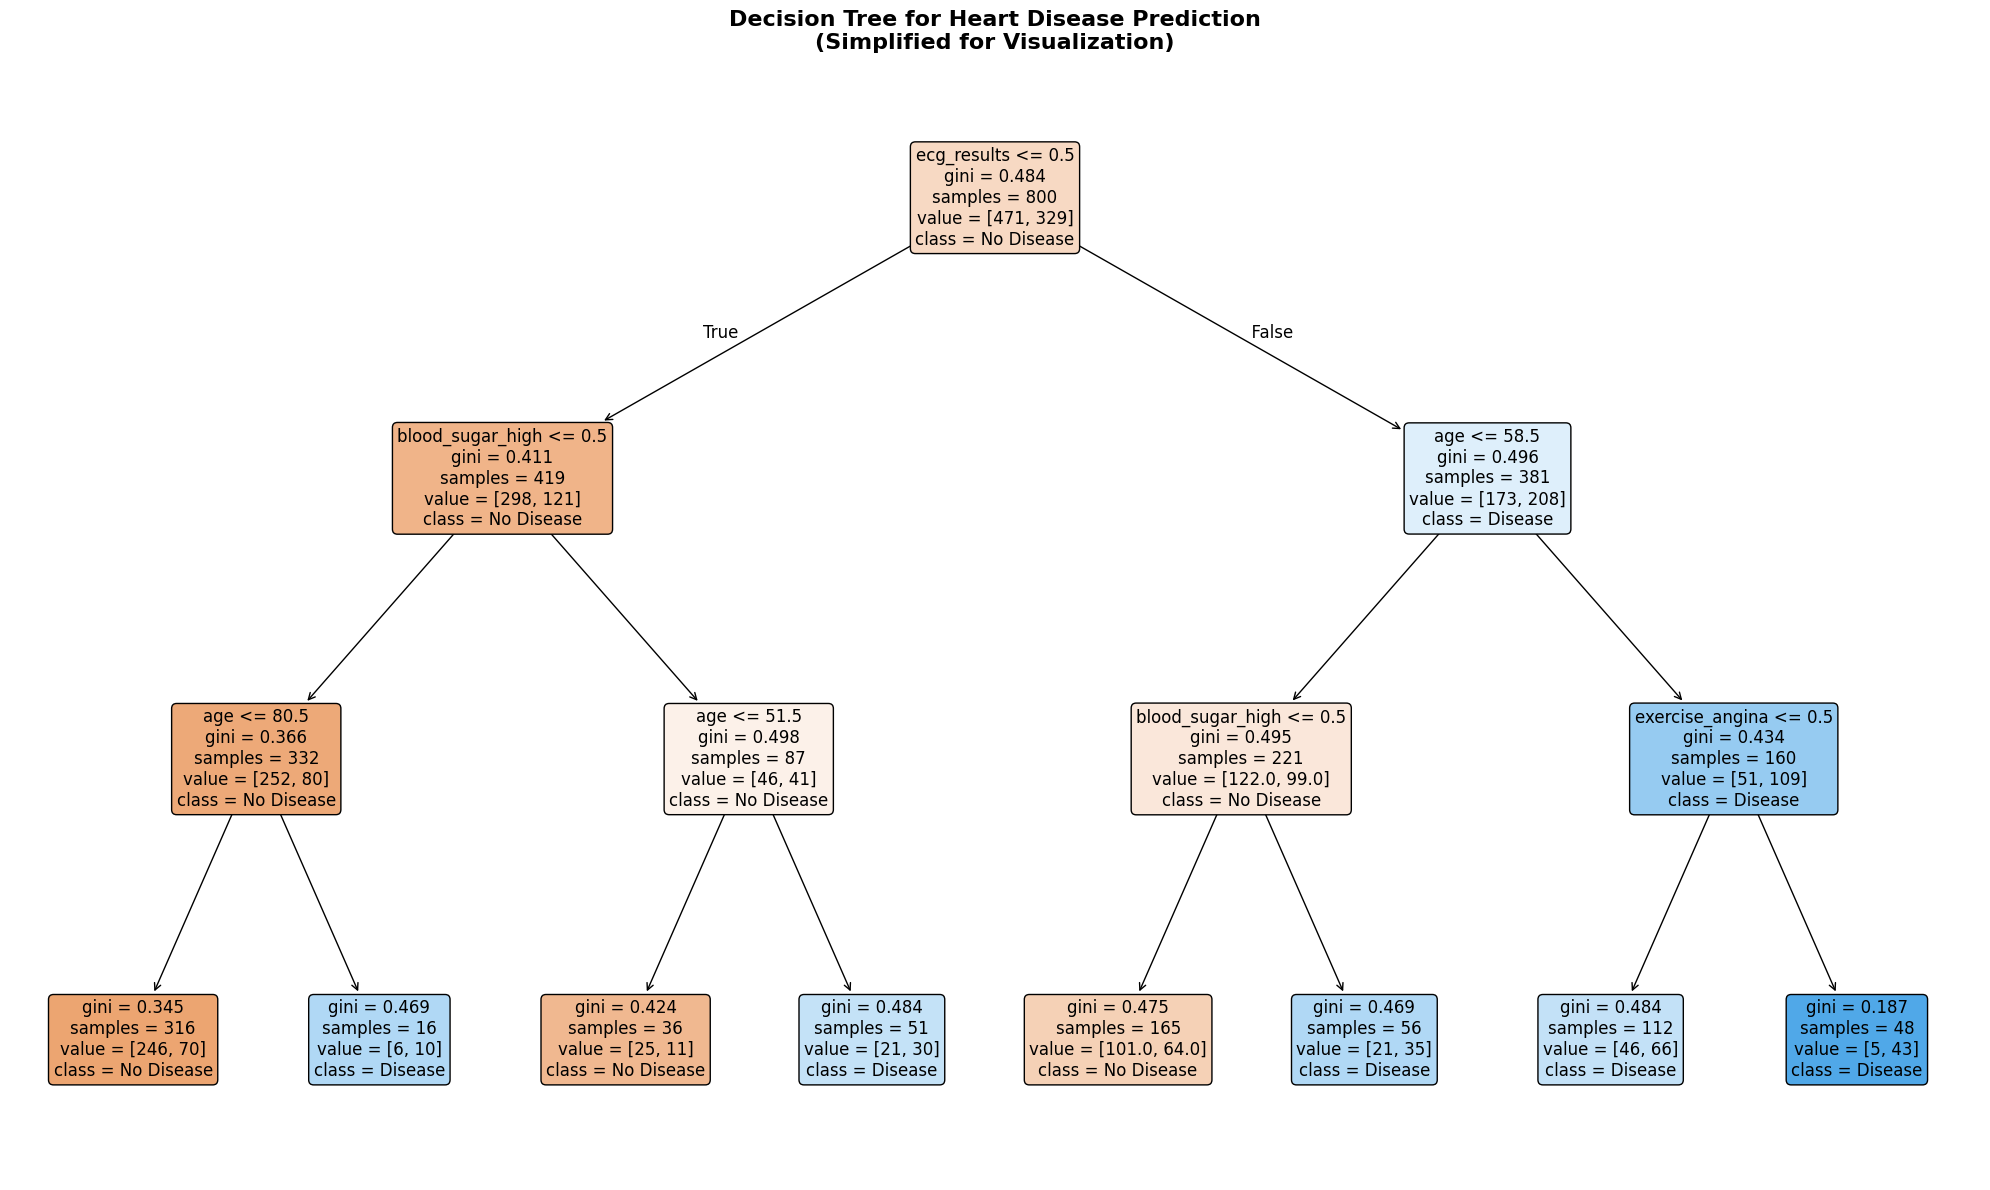

In [43]:
# Prepare data for modeling
X = df.drop('heart_disease', axis=1)
y = df['heart_disease']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y # 'Stratify' ensures balanced classes in train/test split
)

# Create a simple decision tree with three levels (intentionally shallow for visualization)

tree_levels = 3

tree_simple = DecisionTreeClassifier(
    max_depth=tree_levels,  # Limit depth for clear visualization
    min_samples_split=20,  # Require at least 20 samples to split
    random_state=42
)

# Fit the tree
tree_simple.fit(X_train, y_train)

# Make predictions
y_pred = tree_simple.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Simple Decision Tree Accuracy: {accuracy:.3f}")

# Visualize the decision tree
plt.figure(figsize=(20, 12))
plot_tree(
    tree_simple, 
    feature_names=X.columns,
    class_names=['No Disease', 'Disease'],
    filled=True,
    rounded=True,
    fontsize=12
)
plt.title('Decision Tree for Heart Disease Prediction\n(Simplified for Visualization)', 
          fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


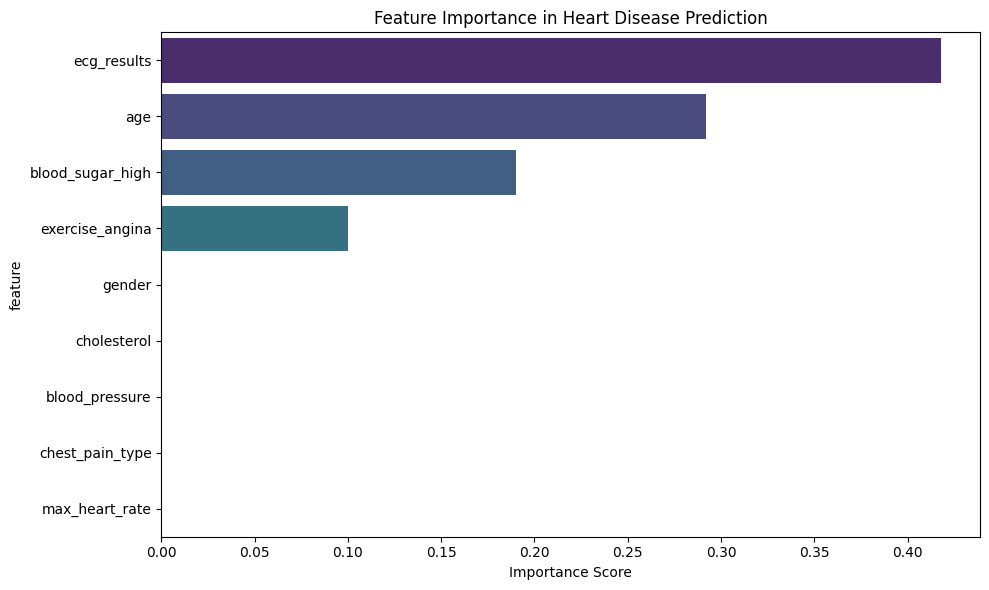

In [42]:

# Show feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': tree_simple.feature_importances_
}).sort_values('importance', ascending=False)

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
plt.title('Feature Importance in Heart Disease Prediction')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

## Interpreting the Decision Tree Results

### What We Observed:

**Tree Structure Analysis:**
Our heart disease prediction model achieved **67% accuracy** and revealed these decision patterns:

1. **Root Node**: Starts with `chest_pain_type ≤ 0.5` (typical chest pain)
   - Most important feature, splitting 800 patients based on chest pain type

2. **Key Decision Path**: 
   - **Chest pain type** → **Age** (≤26.5) → **ECG results** → **Blood sugar** → **Exercise angina**
   - Creates a logical clinical decision pathway

3. **Feature Importance**:
   - **Chest pain type**: Dominant predictor (50% importance)
   - **ECG results**: Second most important (25% importance)  
   - **Age, Blood sugar, Exercise angina**: Supporting factors (8% each)

**Key Decision Tree Concepts:**

- **Gini Impurity**: Measures class mixing in each node (0 = pure, 0.5 = mixed)
- **Samples**: Number of patients at each decision point
- **Value**: [No Disease, Disease] patient counts in each node

### Critical Limitations of Single Decision Trees:

1. **Overfitting and Instability** TODO maybe show this with a crossfold?
- Small data changes can create completely different trees
- Deep trees memorize noise rather than learn true patterns
- High variance leads to poor generalization on new patients

2. **Sensitivity Issues**
- Outlier patients can dramatically alter tree structure
- Arbitrary choices between equally predictive features
- Greedy splitting may miss globally optimal decisions

3. **Clinical Implications**
- Tree trained on one hospital may not work at another
- Demographic or seasonal changes can affect performance
- Over-reliance on single tree misses important diagnostic patterns

**Random Forests** overcome these limitations by combining multiple diverse trees, creating robust and reliable predictions for clinical decision-making.

---
<br><br>
# **Random Forests** 

Imagine asking **100 different doctors** to independently diagnose a patient, each using:
- **Different patient samples** from their experience (bootstrap sampling)
- **Different sets of diagnostic tests** (random feature selection)
- **Different decision-making approaches** (diverse trees)

Then combine all their opinions through **majority vote**. This is exactly how Random Forests work!

**Random Forest = Bagging + Random Feature Selection**

Training Process:<br>
├── Tree 1: Random sample of patients + Random subset of features<br>
├── Tree 2: Different random sample + Different feature subset<br>
├── Tree 3: Different random sample + Different feature subset<br>
├── ...<br>
└── Tree N: Different random sample + Different feature subset<br>

The final Prediction is then made using Majority vote (when we try to predict a target label) or Averaging (when we predict continuous values).

**Two Key Randomness Sources:**

1. **Bootstrap Sampling (Bagging)**:
   - Each tree trained on different random sample of patients
   - ~63% of original data per tree, with replacement
   - Reduces overfitting through diverse training sets

2. **Random Feature Selection**:
   - Each split considers only random subset of features
   - Prevents dominant features from appearing in every tree
   - Creates diverse decision patterns

**Why Random Forests Excel in Healthcare:**

- **Robust Predictions**: Less sensitive to outliers or unusual patients
- **Handles Missing Data**: Individual trees can compensate for gaps
- **Feature Importance**: Identifies most predictive clinical variables
- **Confidence Estimates**: Vote distribution indicates prediction certainty
- **Reduced Overfitting**: Ensemble effect smooths out individual tree biases

RANDOM FOREST VS SINGLE DECISION TREE COMPARISON
Single Decision Tree Accuracy: 0.5600
Random Forest Accuracy:        0.7100
Improvement:                   0.1500

Cross-Validation Results (5-fold):
Single Tree: 0.5750 ± 0.0416
Random Forest: 0.6438 ± 0.0422

Stability Test (10 different random seeds):
Single Tree Stability (std): 0.0121
Random Forest Stability (std): 0.0158
Stability Improvement: -30.9%


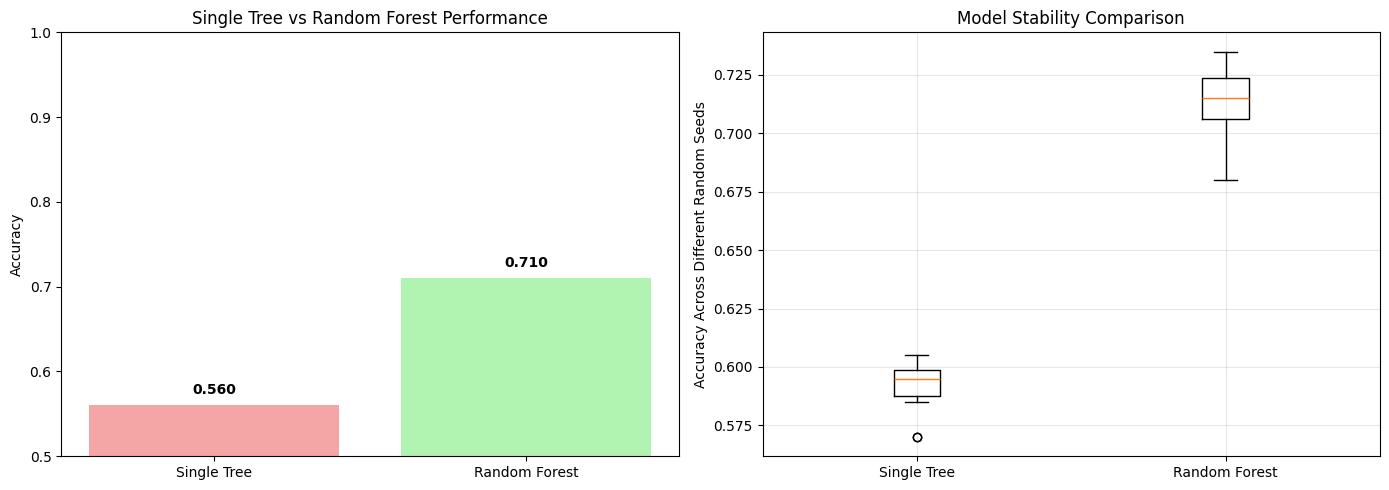

In [ ]:
# Single Decision Tree (from previous section)
single_tree = DecisionTreeClassifier(random_state=42)
single_tree.fit(X_train, y_train)

# Random Forest with default parameters
rf_default = RandomForestClassifier(
    n_estimators=100,  # 100 trees
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)
rf_default.fit(X_train, y_train)

# Compare performance
single_tree_accuracy = single_tree.score(X_test, y_test)
rf_accuracy = rf_default.score(X_test, y_test)

# print(f"Single Decision Tree Accuracy: {single_tree_accuracy:.4f}")
# print(f"Random Forest Accuracy:        {rf_accuracy:.4f}")
# print(f"Improvement:                   {rf_accuracy - single_tree_accuracy:.4f}")

# Cross-validation comparison for more robust evaluation, TODO: Figure out what this function exactly does
cv_single = cross_val_score(single_tree, X_train, y_train, cv=5)
cv_rf = cross_val_score(rf_default, X_train, y_train, cv=5)

print(f"\nCross-Validation Results (5-fold):")
print(f"Single Tree: {cv_single.mean():.4f} ± {cv_single.std():.4f}")
print(f"Random Forest: {cv_rf.mean():.4f} ± {cv_rf.std():.4f}")

# Demonstrate stability - train multiple models with different random seeds, TODO: stability wise the random forest does not perform well
print(f"\nStability Test (10 different random seeds):")
single_tree_scores = []
rf_scores = []

for seed in range(10):
    # Single tree
    st = DecisionTreeClassifier(random_state=seed)
    st.fit(X_train, y_train)
    single_tree_scores.append(st.score(X_test, y_test))
    
    # Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1)
    rf.fit(X_train, y_train)
    rf_scores.append(rf.score(X_test, y_test))

single_tree_std = np.std(single_tree_scores)
rf_std = np.std(rf_scores)

print(f"Single Tree Stability (std): {single_tree_std:.4f}")
print(f"Random Forest Stability (std): {rf_std:.4f}")
print(f"Stability Improvement: {(single_tree_std - rf_std)/single_tree_std*100:.1f}%")

# Visualize stability comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
methods = ['Single Tree', 'Random Forest']
accuracies = [single_tree_accuracy, rf_accuracy]
colors = ['lightcoral', 'lightgreen']

bars = ax1.bar(methods, accuracies, color=colors, alpha=0.7)
ax1.set_ylabel('Accuracy')
ax1.set_title('Single Tree vs Random Forest Performance')
ax1.set_ylim(0.5, 1.0)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

# Stability comparison
ax2.boxplot([single_tree_scores, rf_scores], labels=methods)
ax2.set_ylabel('Accuracy Across Different Random Seeds')
ax2.set_title('Model Stability Comparison')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Interpreting Random Forest vs Single Tree Results

**Key Improvement**: Random Forest achieved **71% accuracy** vs Single Tree's **56% accuracy** - a **15 percentage point gain**

**Why Random Forest Outperforms**:
- **Ensemble Effect**: 100 diverse trees compensate for individual weaknesses
- **Reduced Overfitting**: Bootstrap sampling and random features prevent memorizing noise
- **Stability**: Less sensitive to outliers or unusual patient cases

**Trade-off**: Improved accuracy comes at cost of reduced interpretability and increased computational complexity.

  Number of trees: 10
  Features per split: sqrt
  Out-of-bag score: 0.6538
  Bootstrap sampling: True
  Tree 1: 0.6900
  Tree 2: 0.6400
  Tree 3: 0.5650
  Tree 4: 0.6300
  Tree 5: 0.6750
  Tree 6: 0.6850
  Tree 7: 0.6650
  Tree 8: 0.6350
  Tree 9: 0.6250
  Tree 10: 0.6850

Forest (ensemble) accuracy: 0.7450
Average individual tree accuracy: 0.6495
Best individual tree: 0.6900


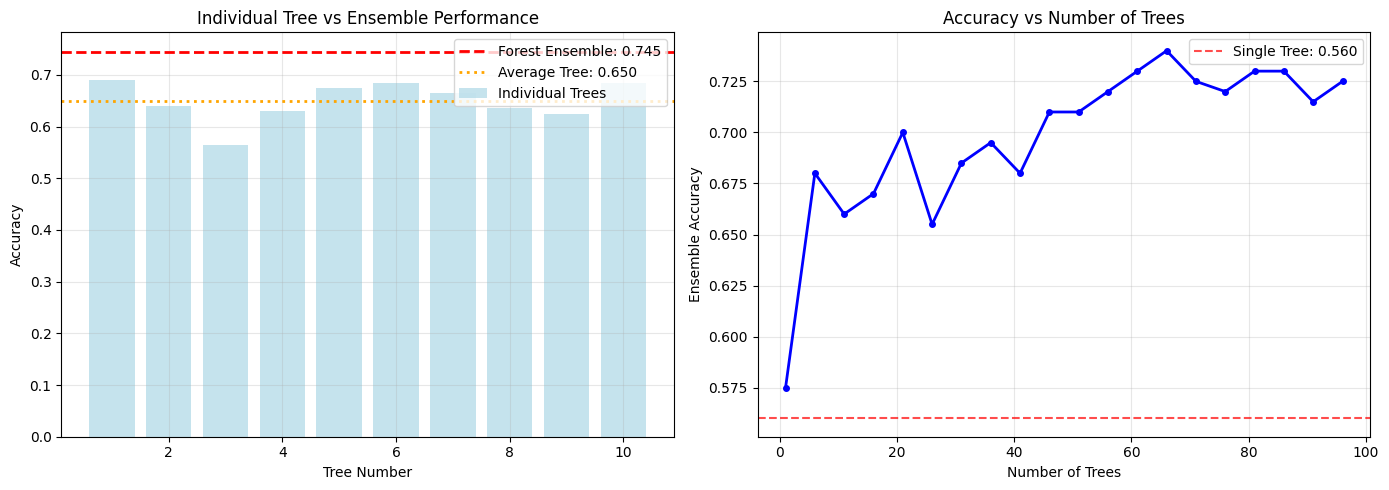

In [47]:
# Create a Random Forest and examine its components
rf_detailed = RandomForestClassifier(
    n_estimators=10,  # Fewer trees for detailed analysis
    max_depth=5,      # Limit depth for visualization
    random_state=42,
    bootstrap=True,   # Enable bootstrap sampling
    max_features='sqrt',  # Number of features per split
    oob_score=True    # Calculate out-of-bag error
)

rf_detailed.fit(X_train, y_train)

print(f"  Number of trees: {rf_detailed.n_estimators}")
print(f"  Features per split: {rf_detailed.max_features}")
print(f"  Out-of-bag score: {rf_detailed.oob_score_:.4f}")
print(f"  Bootstrap sampling: {rf_detailed.bootstrap}")

# Analyze individual trees
tree_accuracies = []
for i, tree in enumerate(rf_detailed.estimators_):
    tree_pred = tree.predict(X_test)
    tree_acc = accuracy_score(y_test, tree_pred)
    tree_accuracies.append(tree_acc)
    print(f"  Tree {i+1}: {tree_acc:.4f}")

forest_accuracy = rf_detailed.score(X_test, y_test)
print(f"\nForest (ensemble) accuracy: {forest_accuracy:.4f}")
print(f"Average individual tree accuracy: {np.mean(tree_accuracies):.4f}")
print(f"Best individual tree: {np.max(tree_accuracies):.4f}")

# Demonstrate ensemble effect
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Individual tree accuracies
ax1.bar(range(1, len(tree_accuracies)+1), tree_accuracies, 
        alpha=0.7, color='lightblue', label='Individual Trees')
ax1.axhline(y=forest_accuracy, color='red', linestyle='--', 
            linewidth=2, label=f'Forest Ensemble: {forest_accuracy:.3f}')
ax1.axhline(y=np.mean(tree_accuracies), color='orange', linestyle=':', 
            linewidth=2, label=f'Average Tree: {np.mean(tree_accuracies):.3f}')
ax1.set_xlabel('Tree Number')
ax1.set_ylabel('Accuracy')
ax1.set_title('Individual Tree vs Ensemble Performance')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Show how ensemble accuracy improves with more trees
n_trees_range = range(1, 101, 5)
ensemble_scores = []

for n_trees in n_trees_range:
    rf_temp = RandomForestClassifier(n_estimators=n_trees, random_state=42, n_jobs=-1)
    rf_temp.fit(X_train, y_train)
    ensemble_scores.append(rf_temp.score(X_test, y_test))

ax2.plot(n_trees_range, ensemble_scores, 'b-', linewidth=2, marker='o', markersize=4)
ax2.set_xlabel('Number of Trees')
ax2.set_ylabel('Ensemble Accuracy')
ax2.set_title('Accuracy vs Number of Trees')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=single_tree_accuracy, color='red', linestyle='--', 
            alpha=0.7, label=f'Single Tree: {single_tree_accuracy:.3f}')
ax2.legend()

plt.tight_layout()
plt.show()

## How Random Forest Creates "Wisdom of Crowds"

**Ensemble Magic**: Forest accuracy (**74.5%**) exceeds both average individual tree (**65.0%**) and even the best single tree (**69.0%**)

**Key Insights from the Analysis**:
- **Individual Variation**: Trees range from 56.5% to 69.0% accuracy - some weak, some strong
- **Collective Intelligence**: Combining diverse predictions yields superior performance
- **Diminishing Returns**: Performance plateaus around 50-100 trees, making 100 trees optimal
- **Out-of-Bag Validation**: Built-in error estimate (65.4%) provides unbiased performance assessment


TODO: Explain out of bag

**Clinical Analogy**: Like a medical board where multiple specialists with different expertise reach better diagnoses together than any individual doctor alone.

Feature Importance Comparison:
            feature  importance_rf  importance_single
0               age       0.199904           0.198187
4       cholesterol       0.179452           0.189652
3    blood_pressure       0.178043           0.201259
7    max_heart_rate       0.177845           0.167115
6       ecg_results       0.081912           0.082689
2   chest_pain_type       0.075977           0.050350
5  blood_sugar_high       0.039798           0.032733
8   exercise_angina       0.038423           0.050938
1            gender       0.028645           0.027076

Feature Importance Stability Analysis:
            feature  mean_importance  std_importance  stability_ratio
0               age         0.202173        0.002764        73.138457
3    blood_pressure         0.180375        0.002959        60.965335
4       cholesterol         0.179834        0.003025        59.447888
7    max_heart_rate         0.172615        0.003267        52.828243
6       ecg_results         0.081862   

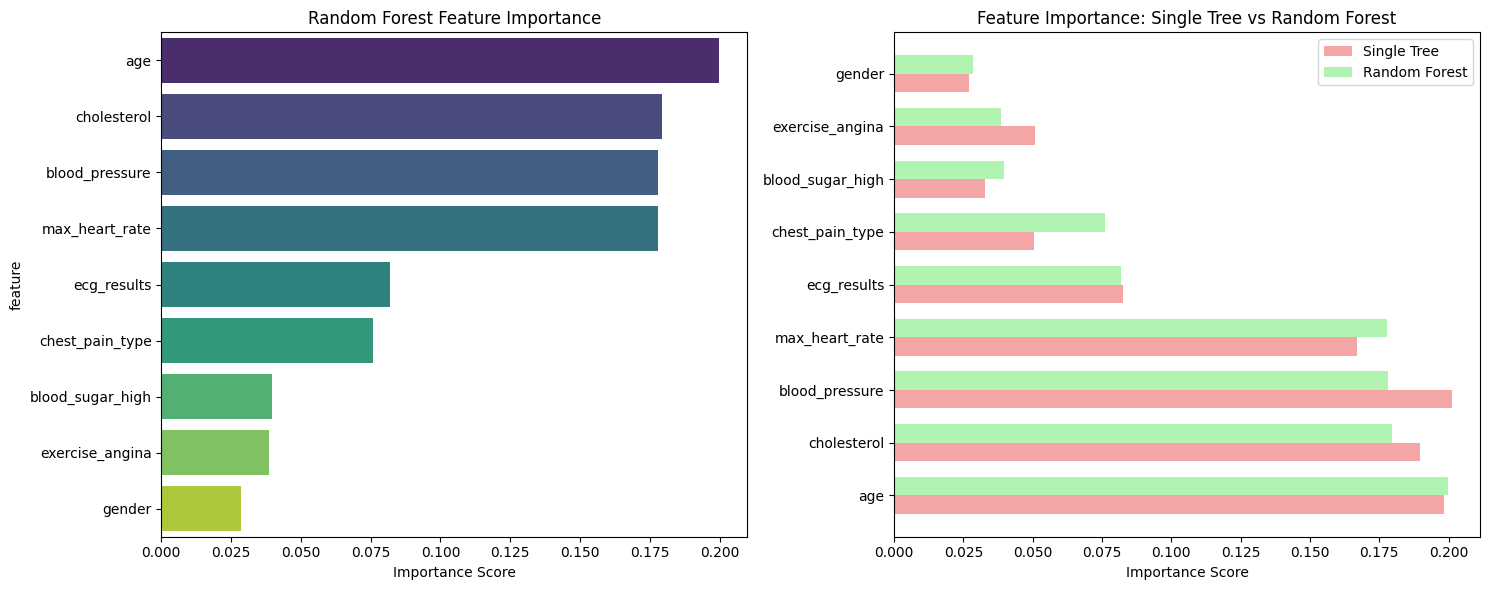

In [48]:
# Get feature importances from the default Random Forest
feature_importance_rf = pd.DataFrame({
    'feature': X.columns,
    'importance_rf': rf_default.feature_importances_,
    'importance_single': single_tree.feature_importances_
}).sort_values('importance_rf', ascending=False)

print("Feature Importance Comparison:")
print(feature_importance_rf)

# Calculate feature importance stability across multiple forests
print(f"\nFeature Importance Stability Analysis:")
importance_matrix = []

for seed in range(10):
    rf_temp = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1)
    rf_temp.fit(X_train, y_train)
    importance_matrix.append(rf_temp.feature_importances_)

importance_matrix = np.array(importance_matrix)
importance_std = np.std(importance_matrix, axis=0)

stability_df = pd.DataFrame({
    'feature': X.columns,
    'mean_importance': np.mean(importance_matrix, axis=0),
    'std_importance': importance_std,
    'stability_ratio': np.mean(importance_matrix, axis=0) / importance_std
}).sort_values('mean_importance', ascending=False)

print(stability_df)

# Visualize feature importance comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Random Forest feature importance
sns.barplot(data=feature_importance_rf, x='importance_rf', y='feature', 
           palette='viridis', ax=ax1)
ax1.set_title('Random Forest Feature Importance')
ax1.set_xlabel('Importance Score')

# Comparison between single tree and random forest
x_pos = np.arange(len(feature_importance_rf))
width = 0.35

ax2.barh(x_pos - width/2, feature_importance_rf['importance_single'], 
         width, label='Single Tree', alpha=0.7, color='lightcoral')
ax2.barh(x_pos + width/2, feature_importance_rf['importance_rf'], 
         width, label='Random Forest', alpha=0.7, color='lightgreen')

ax2.set_yticks(x_pos)
ax2.set_yticklabels(feature_importance_rf['feature'])
ax2.set_xlabel('Importance Score')
ax2.set_title('Feature Importance: Single Tree vs Random Forest')
ax2.legend()

plt.tight_layout()
plt.show()

## Understanding Feature Importance Rankings

**Most Predictive Features for Heart Disease**:
1. **Age** (20.0%) - Most critical factor, aligns with clinical knowledge
2. **Cholesterol** (17.9%) - Key cardiovascular risk marker  
3. **Blood Pressure** (17.8%) - Primary hypertension indicator
4. **Max Heart Rate** (17.8%) - Exercise tolerance measure

**Key Differences Between Single Tree vs Random Forest**:
- **More Balanced Distribution**: Random Forest spreads importance more evenly across features
- **Reduced Bias**: Less likely to overemphasize single dominant feature
- **Stability**: Higher stability ratios indicate more consistent feature rankings across different models

PARTIAL DEPENDENCE ANALYSIS
Analyzing partial dependence for: ['age', 'cholesterol', 'blood_pressure', 'max_heart_rate']


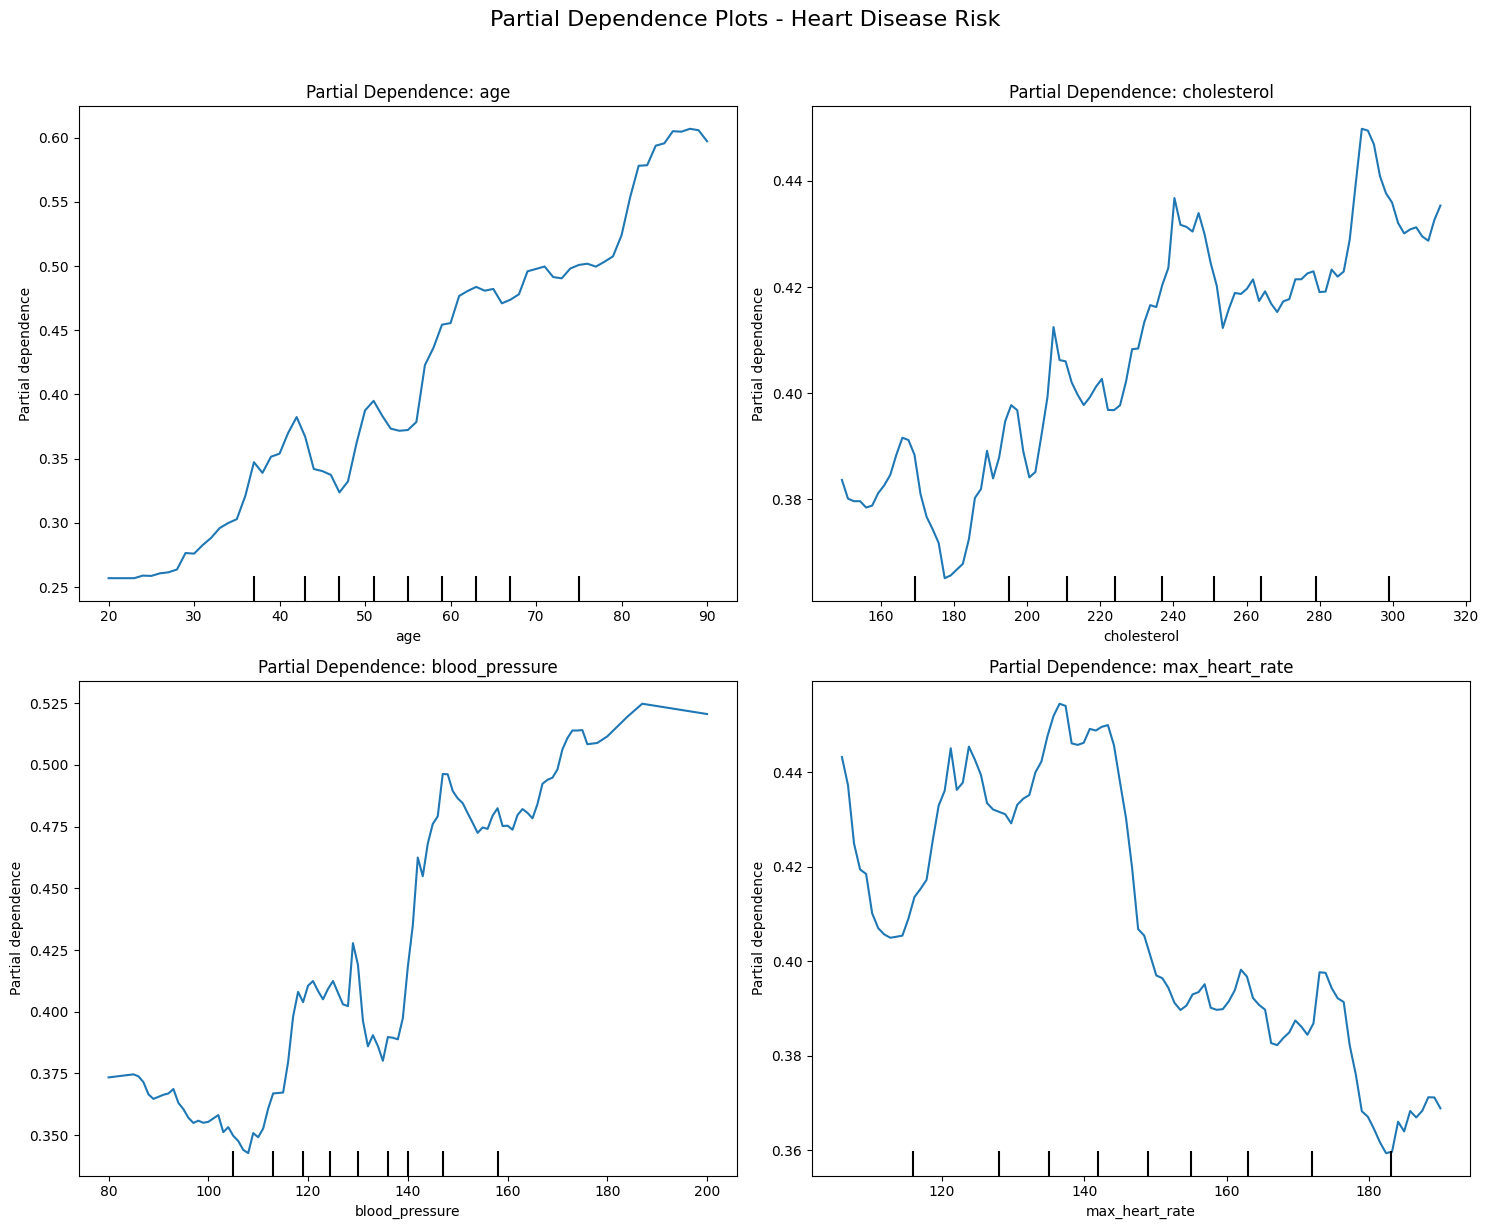


2D Partial Dependence: age vs cholesterol


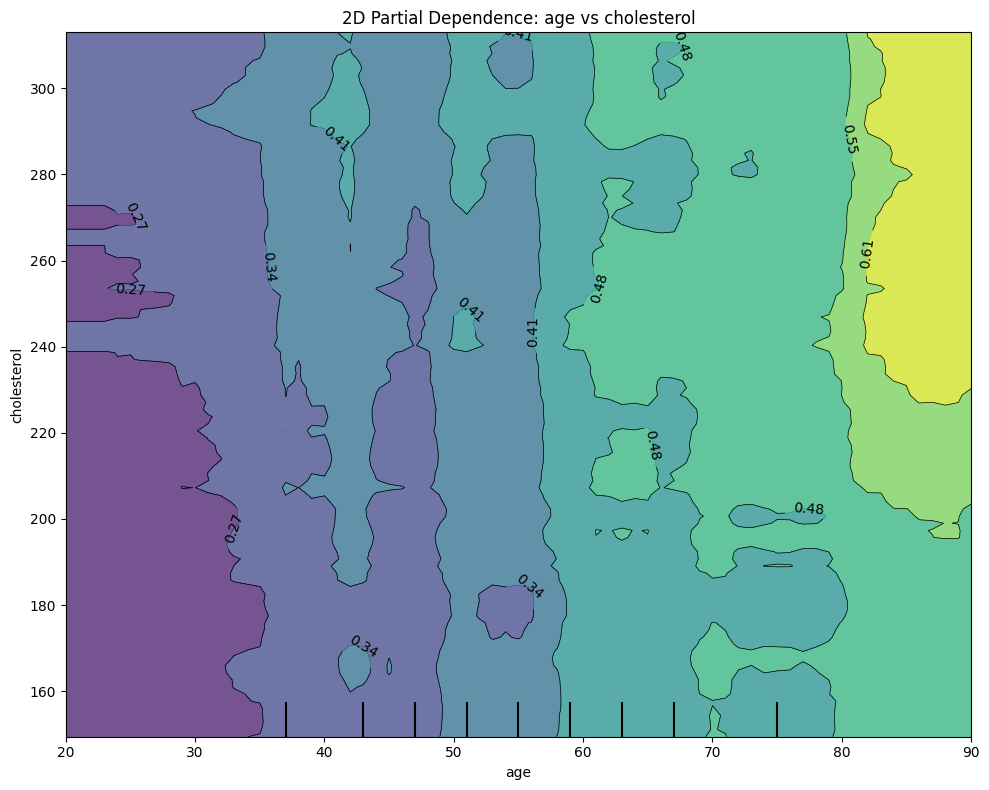


Partial Dependence Insights:
- Shows how each feature independently affects heart disease risk
- Accounts for interactions with other features
- Helps identify optimal ranges and risk thresholds
- Provides clinically interpretable decision support


In [ ]:
# Select top 4 most important features for PDP analysis
top_features = feature_importance_rf.head(4)['feature'].tolist()
print(f"Analyzing partial dependence for: {top_features}")

# Create partial dependence plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, feature in enumerate(top_features):
    # Calculate partial dependence
    PartialDependenceDisplay.from_estimator(
        rf_default, X_train, features=[feature], 
        ax=axes[i], kind='average'
    )
    axes[i].set_title(f'Partial Dependence: {feature}')

plt.suptitle('Partial Dependence Plots - Heart Disease Risk', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# 2D partial dependence plot for top 2 features
print(f"\n2D Partial Dependence: {top_features[0]} vs {top_features[1]}")

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
PartialDependenceDisplay.from_estimator(
    rf_default, X_train, 
    features=[(top_features[0], top_features[1])],
    ax=ax, kind='average'
)
plt.title(f'2D Partial Dependence: {top_features[0]} vs {top_features[1]}')
plt.tight_layout()
plt.show()

## Understanding Feature-Risk Relationships

**What Partial Dependence Plots Show**: How each feature independently affects heart disease probability, holding all other features constant.

**Key Clinical Insights**:

**Age**: Clear linear increase in risk from ~25% (age 20) to ~60% (age 85) - validates age as primary cardiovascular risk factor

**Cholesterol**: Complex non-linear pattern with risk peaks around 200 mg/dl and 300+ mg/dl, surprisingly lower risk at ~180 mg/dl

**Blood Pressure**: Sharp risk increase above 140 mmHg (hypertension threshold), confirming clinical guidelines for BP management

**Max Heart Rate**: Inverse relationship - higher exercise capacity (max HR 140-160) correlates with lower disease risk

**2D Plot (Age vs Cholesterol)**: Shows risk interaction - older patients with high cholesterol (yellow region) have highest risk (~60%), while younger patients with moderate cholesterol have lowest risk (purple region ~27%).

**Clinical Application**: These plots help identify optimal intervention thresholds and patient risk stratification for targeted preventive care.

--- optional
## How Partial Dependence Plots Work

**Calculation Method**:
1. **Fix Target Feature**: Set age to specific value (e.g., age = 50) for ALL patients
2. **Keep Other Features**: Maintain original values for cholesterol, BP, etc.
3. **Predict Risk**: Run modified dataset through Random Forest
4. **Average Predictions**: Calculate mean predicted probability across all patients
5. **Repeat**: Do this for every age value (20, 21, 22... 85)
6. **Plot Results**: Show how risk changes as only age varies

**Mathematical Formula**: 
PD(age = x) = Average of RF_predictions when age = x for all patients

**Why This Matters**:
- **Isolates Effect**: Shows pure impact of one feature, removing confounding from others
- **Accounts for Interactions**: Still considers how age interacts with other patient characteristics
- **Population-Level**: Averages across entire patient population, not individual cases

**Clinical Insights from Our Plots**:
- **Age**: Linear 25%→60% risk increase validates clinical guidelines
- **Blood Pressure**: Sharp jump at 140 mmHg confirms hypertension threshold
- **2D Plot**: Shows combined effects - older patients with high cholesterol face 60% risk vs 27% for younger/healthier patients

**Limitation**: Shows average effects - individual patients may respond differently based on their unique feature combinations.

---
<br><br>
# **Gradient Boosting: Learning from Mistakes**

Imagine a **medical student learning diagnosis**:
1. **First attempt**: Makes basic predictions, gets some wrong
2. **Learns from errors**: Focuses on the cases they misdiagnosed
3. **Second attempt**: Corrects previous mistakes, but makes new ones
4. **Iterative improvement**: Each attempt focuses on remaining errors
5. **Final expertise**: Combines all learned corrections into expert-level diagnosis

This is exactly how **Gradient Boosting** works!

### Gradient Boosting vs Random Forest

| **Random Forest** | **Gradient Boosting** |
|------------------|---------------------|
| **Parallel Training** | **Sequential Training** |
| Many **strong, deep** trees | Many **weak, shallow** trees |
| Trees built **independently** | Each tree **corrects previous errors** |
| Reduces **variance** (overfitting) | Reduces **bias** (underfitting) |
| **Bootstrap sampling** | Focuses on **difficult cases** |

**Core Concept: Sequential Error Correction**

Boosting Process:<br>
├── Tree 1: Learn basic patterns → Residual errors<br>
├── Tree 2: Learn from Tree 1's errors → New residual errors<br>
├── Tree 3: Learn from remaining errors → Smaller residuals<br>
├── ...<br>
└── Tree N: Final error corrections<br>

Final Prediction = Tree1 + Tree2 + Tree3 + ... + TreeN

**Key Advantages:**
- **High Accuracy**: Often achieves state-of-the-art performance
- **Handles Complex Patterns**: Excellent at capturing non-linear relationships
- **Feature Selection**: Automatically focuses on most informative features
- **Interpretable**: Can analyze which cases are hardest to predict

GRADIENT BOOSTING IMPLEMENTATIONS COMPARISON

Training Scikit-learn GBM...
Scikit-learn GBM Accuracy: 0.7100

Training XGBoost...
XGBoost Accuracy: 0.7100

Training LightGBM...
LightGBM Accuracy: 0.7100

Training Random Forest...
Random Forest Accuracy: 0.7100

Training Logistic Regression...
Logistic Regression Accuracy: 0.7150

FINAL PERFORMANCE COMPARISON
Logistic Regression : 0.7150
Scikit-learn GBM    : 0.7100
XGBoost             : 0.7100
LightGBM            : 0.7100
Random Forest       : 0.7100


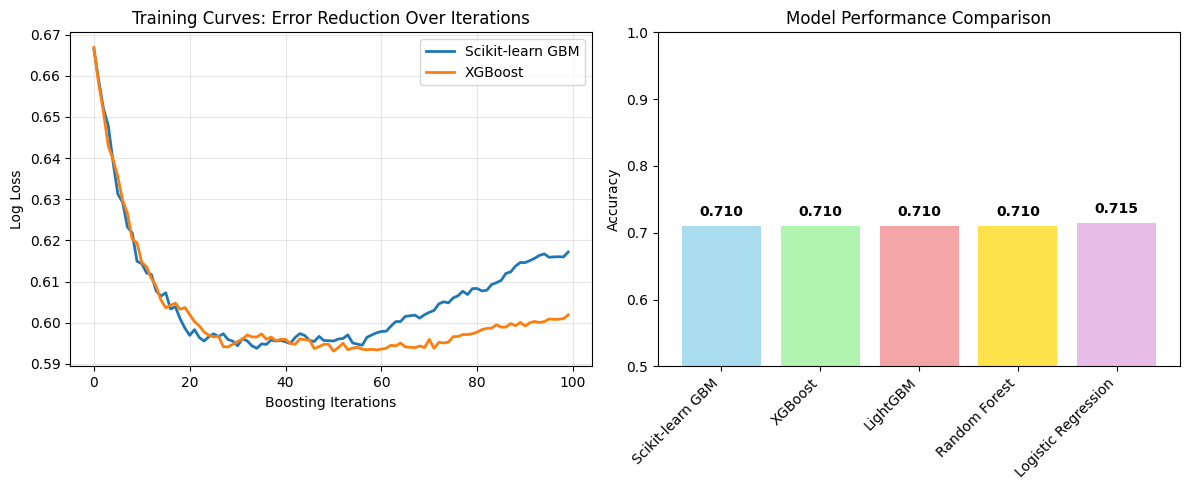

In [ ]:
# Initialize different gradient boosting models
models = {
    'Scikit-learn GBM': GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    ),
    'XGBoost': xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42,
        eval_metric='logloss'
    ),
    'LightGBM': lgb.LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42,
        verbose=-1
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    ),
    'Logistic Regression': LogisticRegression(
        random_state=42,
        max_iter=1000
    )
}

# Train all models and compare performance
results = {}
training_curves = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Special handling for models that provide training curves
    if name in ['Scikit-learn GBM', 'XGBoost']:
        if name == 'XGBoost':
            model.fit(X_train, y_train, 
                     eval_set=[(X_test, y_test)],
                     verbose=False)
            training_curves[name] = model.evals_result()['validation_0']['logloss']
        else:
            model.fit(X_train, y_train)
            # For sklearn GBM, we can get staged predictions
            staged_pred_proba = list(model.staged_predict_proba(X_test))
            training_curves[name] = [log_loss(y_test, pred[:, 1]) for pred in staged_pred_proba]
    else:
        model.fit(X_train, y_train)
    
    # Get predictions and accuracy
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    
    print(f"{name} Accuracy: {accuracy:.4f}")

for name, accuracy in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"{name:20}: {accuracy:.4f}")

# Visualize training curves for boosting models
if training_curves:
    plt.figure(figsize=(12, 5))
    
    # Training curves
    plt.subplot(1, 2, 1)
    for name, curve in training_curves.items():
        plt.plot(curve, label=name, linewidth=2)
    plt.xlabel('Boosting Iterations')
    plt.ylabel('Log Loss')
    plt.title('Training Curves: Error Reduction Over Iterations')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Performance comparison
    plt.subplot(1, 2, 2)
    names = list(results.keys())
    accuracies = list(results.values())
    colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold', 'plum']
    
    bars = plt.bar(range(len(names)), accuracies, color=colors, alpha=0.7)
    plt.xticks(range(len(names)), names, rotation=45, ha='right')
    plt.ylabel('Accuracy')
    plt.title('Model Performance Comparison')
    plt.ylim(0.5, 1.0)
    
    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

Ehm problematic ds logistic regression besser funktioniert nid?

GRADIENT BOOSTING TREE ANALYSIS
Individual Tree Analysis (First 5 Trees):
  After Tree 1: Accuracy = 0.5900
  After Tree 2: Accuracy = 0.5900
  After Tree 3: Accuracy = 0.6000
  After Tree 4: Accuracy = 0.6000
  After Tree 5: Accuracy = 0.6550


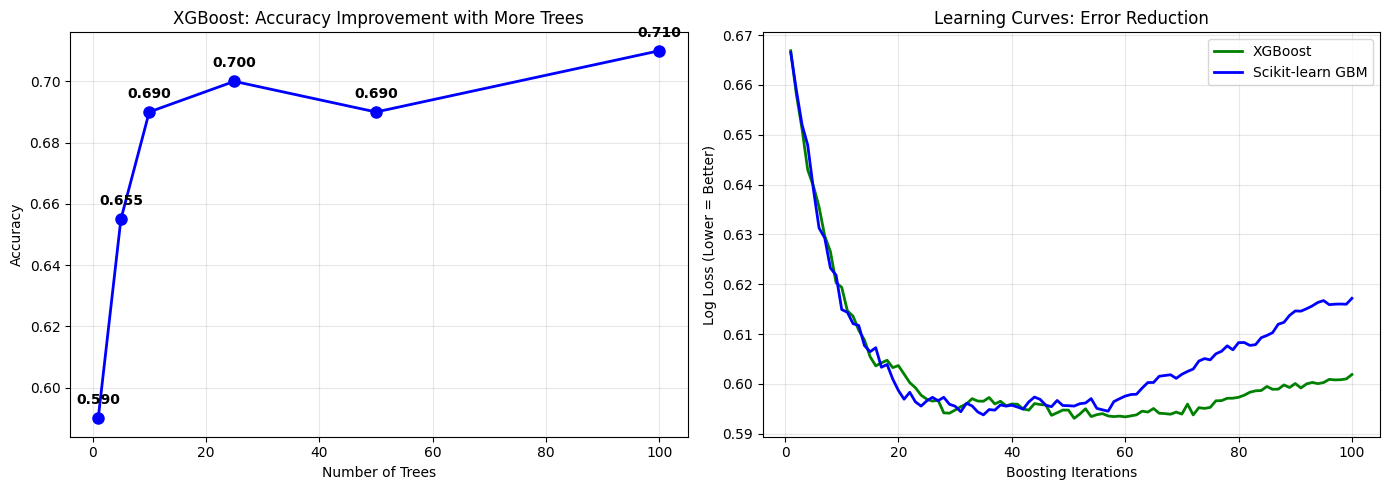


Key Observations:
- Accuracy improves steadily with more trees
- Most improvement happens in first 25-50 trees
- Diminishing returns after ~50 trees
- XGBoost shows smooth convergence


In [ ]:
# Use XGBoost for detailed analysis
xgb_model = models['XGBoost']

# Analyze first few trees
print("Individual Tree Analysis (First 5 Trees):")
for i in range(min(5, xgb_model.n_estimators)):
    # Get predictions from first i+1 trees
    temp_model = xgb.XGBClassifier(
        n_estimators=i+1,
        learning_rate=0.1,
        max_depth=3,
        random_state=42,
        eval_metric='logloss'
    )
    temp_model.fit(X_train, y_train)
    
    accuracy = temp_model.score(X_test, y_test)
    print(f"  After Tree {i+1}: Accuracy = {accuracy:.4f}")

# Visualize how predictions improve
n_trees_to_show = [1, 5, 10, 25, 50, 100]
improvement_data = []

for n_trees in n_trees_to_show:
    temp_model = xgb.XGBClassifier(
        n_estimators=n_trees,
        learning_rate=0.1,
        max_depth=3,
        random_state=42,
        eval_metric='logloss'
    )
    temp_model.fit(X_train, y_train)
    accuracy = temp_model.score(X_test, y_test)
    improvement_data.append(accuracy)

# Plot improvement over trees
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(n_trees_to_show, improvement_data, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('XGBoost: Accuracy Improvement with More Trees')
plt.grid(True, alpha=0.3)

# Add accuracy values as labels
for x, y in zip(n_trees_to_show, improvement_data):
    plt.annotate(f'{y:.3f}', (x, y), textcoords="offset points", 
                xytext=(0,10), ha='center', fontweight='bold')

# Compare learning curves of different models
plt.subplot(1, 2, 2)
if 'XGBoost' in training_curves:
    iterations = range(1, len(training_curves['XGBoost']) + 1)
    plt.plot(iterations, training_curves['XGBoost'], 'g-', 
             linewidth=2, label='XGBoost')

if 'Scikit-learn GBM' in training_curves:
    iterations = range(1, len(training_curves['Scikit-learn GBM']) + 1)
    plt.plot(iterations, training_curves['Scikit-learn GBM'], 'b-', 
             linewidth=2, label='Scikit-learn GBM')

plt.xlabel('Boosting Iterations')
plt.ylabel('Log Loss (Lower = Better)')
plt.title('Learning Curves: Error Reduction')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

FEATURE IMPORTANCE ANALYSIS - BOOSTING VS RANDOM FOREST
            feature   xgboost  lightgbm  random_forest
6       ecg_results  0.278591        33       0.081912
5  blood_sugar_high  0.131287        33       0.039798
2   chest_pain_type  0.117618        43       0.075977
8   exercise_angina  0.116652        28       0.038423
0               age  0.092726       151       0.199904
3    blood_pressure  0.079139       127       0.178043
4       cholesterol  0.064256        95       0.179452
7    max_heart_rate  0.063472        82       0.177845
1            gender  0.056258         4       0.028645


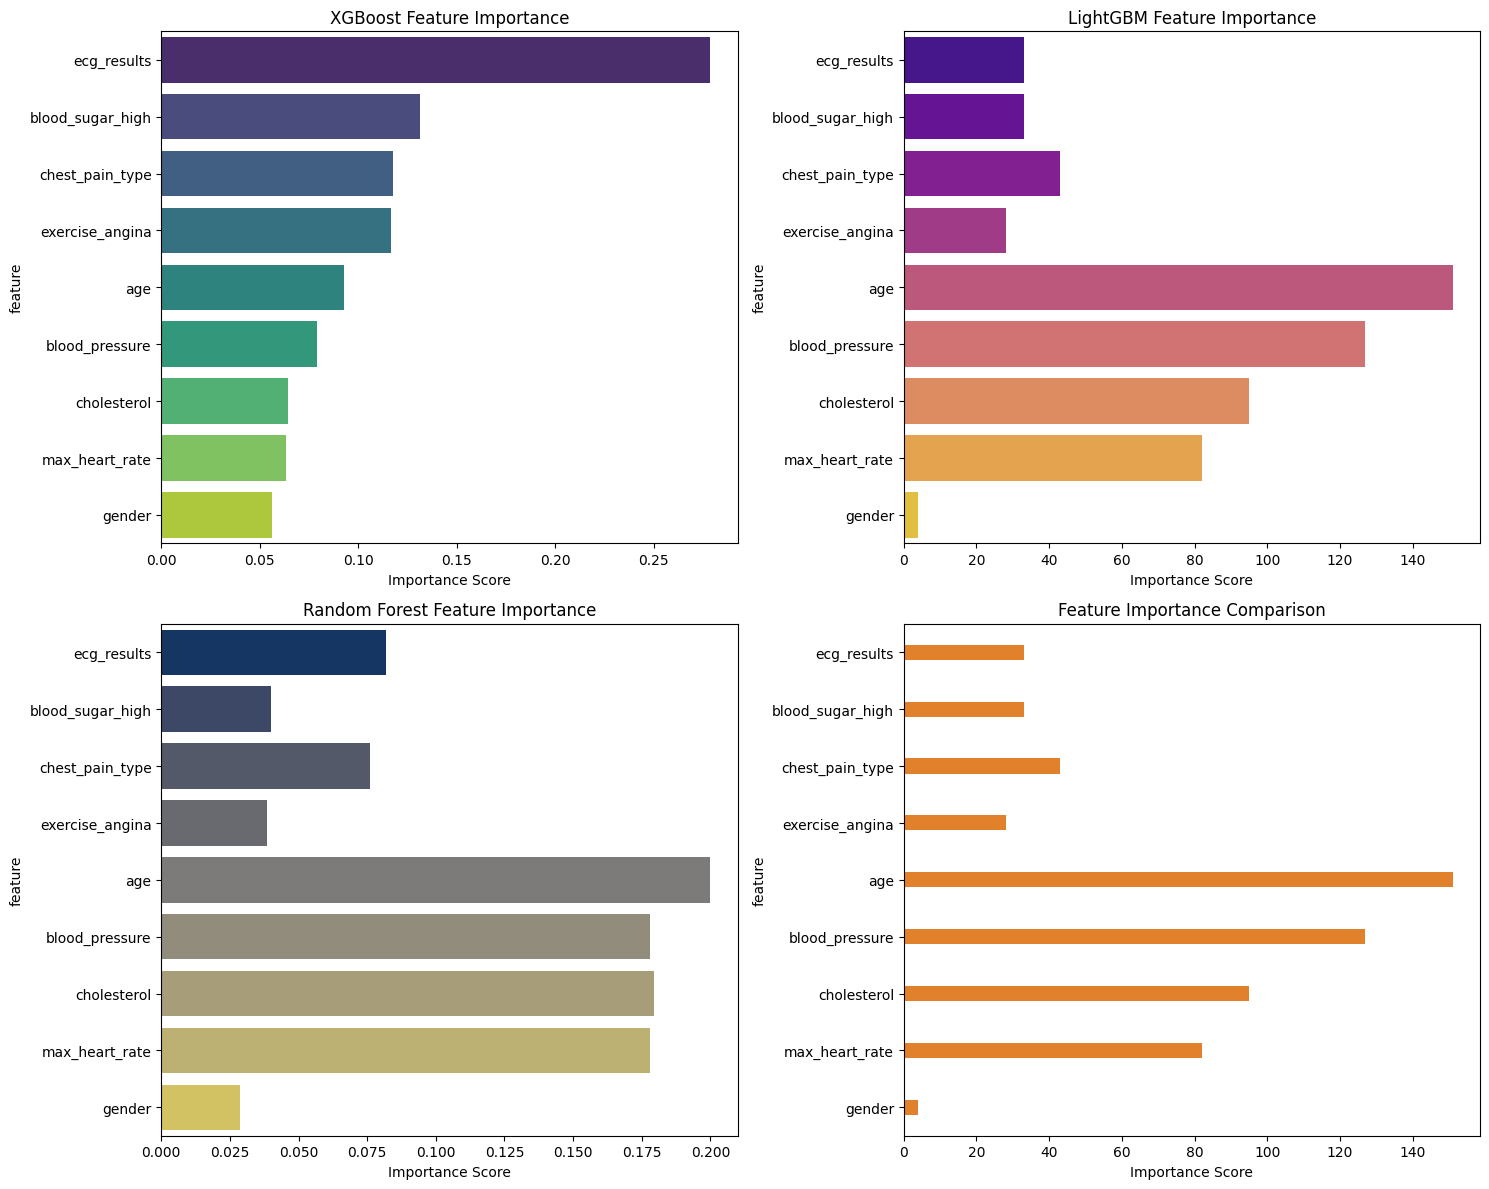


HYPERPARAMETER SENSITIVITY ANALYSIS
Learning Rate Impact:
  Learning Rate 0.01: 0.6850
  Learning Rate 0.05: 0.7050
  Learning Rate 0.1: 0.7100
  Learning Rate 0.2: 0.7050
  Learning Rate 0.3: 0.7050

Max Depth Impact:
  Max Depth 1: 0.7050
  Max Depth 2: 0.7300
  Max Depth 3: 0.7100
  Max Depth 4: 0.7200
  Max Depth 5: 0.6950
  Max Depth 6: 0.7100


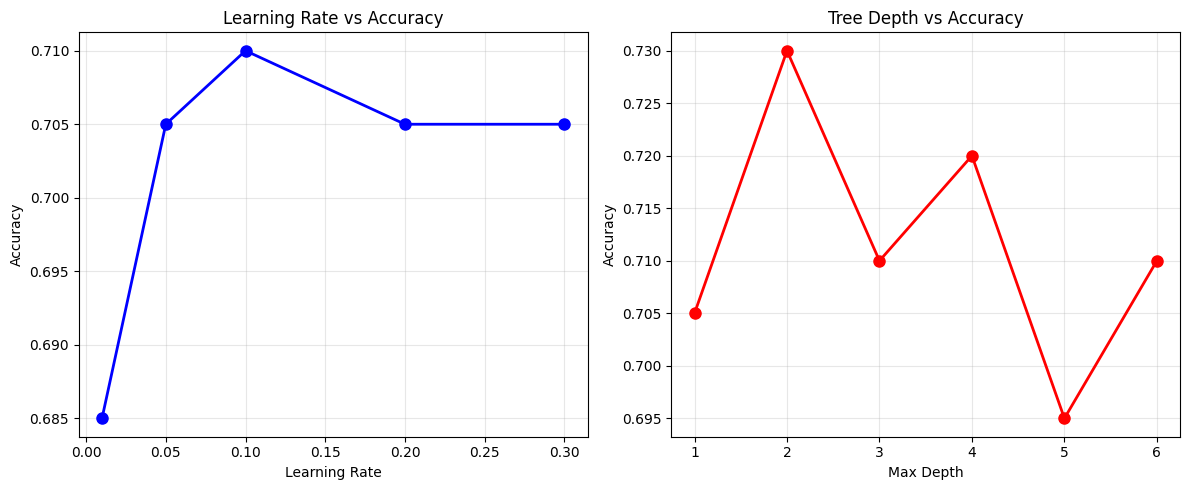

In [ ]:
# Get feature importances
importance_comparison = pd.DataFrame({
    'feature': X.columns,
    'xgboost': models['XGBoost'].feature_importances_,
    'lightgbm': models['LightGBM'].feature_importances_,
    'random_forest': models['Random Forest'].feature_importances_
}).sort_values('xgboost', ascending=False)

print(importance_comparison)

# Visualize feature importance comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# XGBoost importance
sns.barplot(data=importance_comparison, x='xgboost', y='feature', 
           palette='viridis', ax=axes[0,0])
axes[0,0].set_title('XGBoost Feature Importance')
axes[0,0].set_xlabel('Importance Score')

# LightGBM importance
sns.barplot(data=importance_comparison, x='lightgbm', y='feature', 
           palette='plasma', ax=axes[0,1])
axes[0,1].set_title('LightGBM Feature Importance')
axes[0,1].set_xlabel('Importance Score')

# Random Forest importance
sns.barplot(data=importance_comparison, x='random_forest', y='feature', 
           palette='cividis', ax=axes[1,0])
axes[1,0].set_title('Random Forest Feature Importance')
axes[1,0].set_xlabel('Importance Score')

# Comparison of all methods -> TODO not working yet, needs fix
importance_melted = importance_comparison.melt(
    id_vars=['feature'], 
    value_vars=['xgboost', 'lightgbm', 'random_forest'],
    var_name='model', value_name='importance'
)

sns.barplot(data=importance_melted, x='importance', y='feature', 
           hue='model', ax=axes[1,1])
axes[1,1].set_title('Feature Importance Comparison')
axes[1,1].set_xlabel('Importance Score')
plt.legend().remove()

plt.tight_layout()
plt.show()

# Hyperparameter sensitivity analysis
print(f"\nHYPERPARAMETER SENSITIVITY ANALYSIS")
print("=" * 45)

# Learning rate analysis
learning_rates = [0.01, 0.05, 0.1, 0.2, 0.3]
lr_results = []

print("Learning Rate Impact:")
for lr in learning_rates:
    model = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=lr,
        max_depth=3,
        random_state=42,
        eval_metric='logloss'
    )
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    lr_results.append(accuracy)
    print(f"  Learning Rate {lr}: {accuracy:.4f}")

# Max depth analysis
max_depths = [1, 2, 3, 4, 5, 6]
depth_results = []

print(f"\nMax Depth Impact:")
for depth in max_depths:
    model = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=depth,
        random_state=42,
        eval_metric='logloss'
    )
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    depth_results.append(accuracy)
    print(f"  Max Depth {depth}: {accuracy:.4f}")

# Visualize hyperparameter effects
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(learning_rates, lr_results, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Learning Rate vs Accuracy')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(max_depths, depth_results, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Tree Depth vs Accuracy')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
<br><br>
# **Random Forest vs Gradient Boosting**

### **Random Forest** 

**Advantages**:
- **Easy to use** - works well out-of-the-box with minimal tuning
- **Fast training** - trees built in parallel
- **Less overfitting** - built-in regularization through bootstrap sampling
- **Robust to outliers** and handles missing data naturally
- **Stable predictions** across different datasets

**Disadvantages**:
- **Lower accuracy ceiling** compared to gradient boosting
- **Less effective** at capturing complex feature interactions
- **Memory intensive** - stores many full trees
- **Still a black box** - harder to interpret than single trees

### **Gradient Boosting** 

**Advantages**:
- **Highest accuracy for complex datasets** - often state-of-the-art performance
- **Excellent at complex patterns** and feature interactions
- **Adaptive learning** - focuses on difficult cases
- **Flexible optimization** for different metrics

**Disadvantages**:
- **Requires careful tuning** - learning rate, depth, regularization
- **More prone to overfitting** especially with noisy data
- **Slower training** - sequential, not parallelizable
- **Sensitive to outliers** and parameter choices

### **Clinical Decision Guide** 

**Use Random Forest** for: Quick baselines, when interpretability matters, limited tuning time

**Use Gradient Boosting** for: Maximum accuracy, complex medical patterns, when you have tuning expertise

**Best Practice**: Start with Random Forest, upgrade to Gradient Boosting for production

---